In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

# **Dataset Daily Min Temp**

In [4]:
dataset = pd.read_csv('/content/drive/My Drive/BCML/datasets/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=False, date_parser=parser)
dataset.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


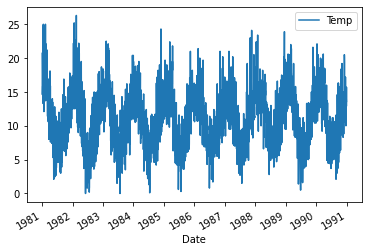

In [5]:
dataset.plot()
plt.show()

In [6]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0        [-2.8000000000000007]
1         [0.9000000000000021]
2         [-4.200000000000001]
3          [1.200000000000001]
4                        [0.0]
                 ...          
3644     [-0.5999999999999996]
3645    [-0.40000000000000036]
3646    [-0.09999999999999964]
3647      [2.1999999999999993]
3648     [-2.6999999999999993]
Length: 3649, dtype: object

In [7]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,[-2.8000000000000007]
1,[-2.8000000000000007],[0.9000000000000021]
2,[0.9000000000000021],[-4.200000000000001]
3,[-4.200000000000001],[1.200000000000001]
4,[1.200000000000001],[0.0]
...,...,...
3644,[1.6999999999999993],[-0.5999999999999996]
3645,[-0.5999999999999996],[-0.40000000000000036]
3646,[-0.40000000000000036],[-0.09999999999999964]
3647,[-0.09999999999999964],[2.1999999999999993]


In [8]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[array([-2.8]), array([0.9])],
       [array([0.9]), array([-4.2])],
       [array([-4.2]), array([1.2])],
       ...,
       [array([-0.4]), array([-0.1])],
       [array([-0.1]), array([2.2])],
       [array([2.2]), array([-2.7])]], dtype=object)

In [9]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Baseline model

In [11]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0958 - val_loss: 0.0704
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0577
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0550
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0546
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0545
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0545
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0545
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0545
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0545
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0544

In [12]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0545
Test loss: 0.05448964610695839


In [13]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
15,0.058687,0.054410,15
38,0.058667,0.054412,38
19,0.058664,0.054413,19
37,0.058662,0.054414,37
17,0.058657,0.054414,17
...,...,...,...
349,0.058717,0.054573,349
3,0.058858,0.054576,3
2,0.059999,0.055019,2
1,0.066636,0.057653,1


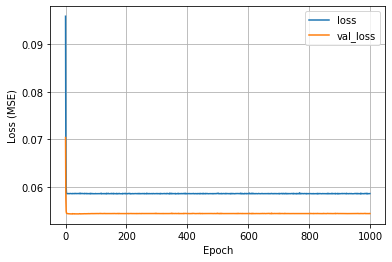

In [14]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [15]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0553
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0550
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0549
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0548
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0548
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0547
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0547
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0546
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0547
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0546

In [16]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
840,0.058131,0.053804,840
903,0.058180,0.053811,903
906,0.058104,0.053812,906
968,0.058106,0.053812,968
786,0.058100,0.053817,786
...,...,...,...
3,0.059966,0.054788,3
4,0.059817,0.054807,4
2,0.060143,0.054875,2
1,0.060461,0.054989,1


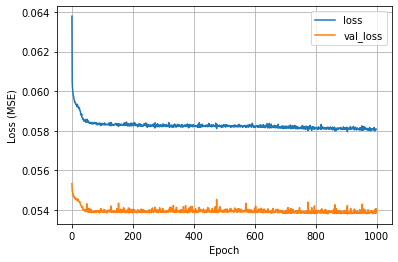

In [17]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [18]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0542
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0541
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0541
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0540
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0540
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0538
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0539

In [19]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
14,0.058331,0.053731,14
19,0.058006,0.053749,19
21,0.057884,0.053765,21
25,0.057931,0.053767,25
28,0.057888,0.053768,28
...,...,...,...
147,0.057885,0.054409,147
855,0.057496,0.054422,855
962,0.057442,0.054427,962
100,0.057875,0.054583,100


# **LSTM**

In [20]:
epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 5ms/step - loss: 0.0647 - val_loss: 0.0550
Epoch 2/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0592 - val_loss: 0.0542
Epoch 3/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0541
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0544
Epoch 10/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0540

In [21]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
351,0.057941,0.053774,351
312,0.057866,0.053777,312
321,0.058022,0.053779,321
340,0.057859,0.053780,340
341,0.057929,0.053782,341
...,...,...,...
349,0.057860,0.054458,349
102,0.058066,0.054489,102
429,0.057927,0.054511,429
240,0.057861,0.054925,240


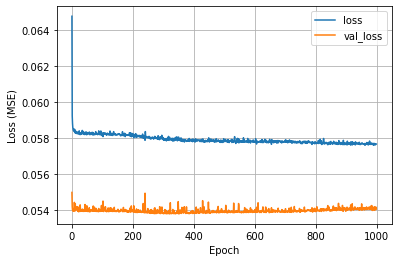

In [22]:
plot_loss(lstm_model_history)

# **Kesimpulan**

Berdasarkan perhitungan diatas didapatkan hasil:

```
Baseline Model: Val_loss 0.054410 Epoch 15
Deeper Model: Val_loss 0.053804 Epoch 840
Wider Model: Val_loss 0.053731 Epoch 14
LSTM: Val_loss 0.053774 Epoch 351
```
melihat dari hasil val_loss yang ada maka dapat di simpulkan **wider model** mendapatkan hasil yang **terbaik** meskipun perbedaannya hanya sedikit tetapi karena val_loss semakin kecil semakin baik jadi kita ambil yang paling kecil.
